Please see [the first chapter where getting the data and processing RNA modality are described](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.ipynb) and [the second chapter with ATAC modality processing](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.ipynb)


This is the third chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, we will see how to learn a latent space jointly on two omics.

In [7]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

# Load libraries and data

Import libraries:

In [51]:
import numpy as np
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
import seaborn as sns

In [17]:
import muon as mu

Load the MuData object from the `.h5mu` file:

In [18]:
mdata = mu.read("data/pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 11165 × 132440
  2 modalities
    atac:	9816 x 106084
      obs:	'n_genes', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	10886 x 26346
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 

In each modality, only cells passing respective QC are retained. For the multimodal data integration, we will use only cells that are present for both modalities:

In [19]:
mu.pp.intersect_obs(mdata)

In [20]:
mdata

MuData object with n_obs × n_vars = 9537 × 132440
  2 modalities
    atac:	9537 x 106084
      obs:	'n_genes', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9537 x 26346
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'u

# Perform integration

We will now run **multi-omic factor analysis** — a group factor analysis method that will allow us to learn an interpretable latent space jointly on both modalities.

The time required to train the model depends on the number of cells and features as well as on hardware specs. For the current dataset, it takes 4 minutes on the GeForce RTX 2080 Ti NVIDIA card.

In [2]:
mu.tl.mofa(mdata, outfile="models/test_pbmc10k_rna_atac.hdf5", 
           save_metadata=True,
           features_subset="highly_variable",
           quiet=False)

In [ ]:
# NOTE: if you wish to load the trained model,
#       use mofax library to quickly add 
#       factors and weights matrices 
#       to the mdata object
# 
# import mofax as mfx
# model = mfx.mofa_model('models/pbmc10k_rna_atac.hdf5')
# mdata.obsm["X_mofa"] = model.get_factors()
# mdata.varm["LFs"] = model.get_weights()
# model.close()

After the training, the embedding will be added to the `obsm` slot of the `mdata`:

In [36]:
mdata.obsm['X_mofa'].shape

(9537, 20)

We can directly use it for plotting with `mu.pl` or `sc.pl` plotting functions — `mdata` has both `.obs` and `.obsm` slots that are needed for plotting:

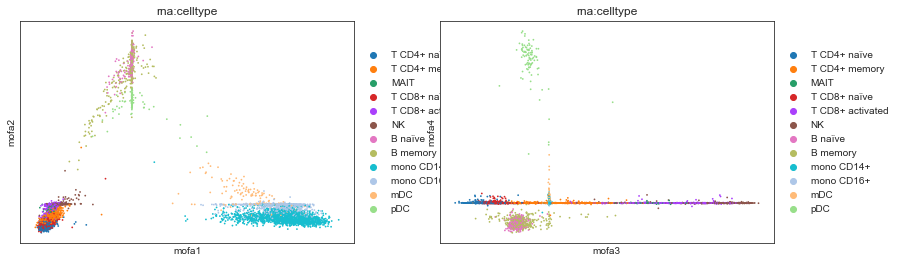

In [99]:
mu.pl.mofa(mdata, color="rna:celltype", components=["1,2", "3,4"])

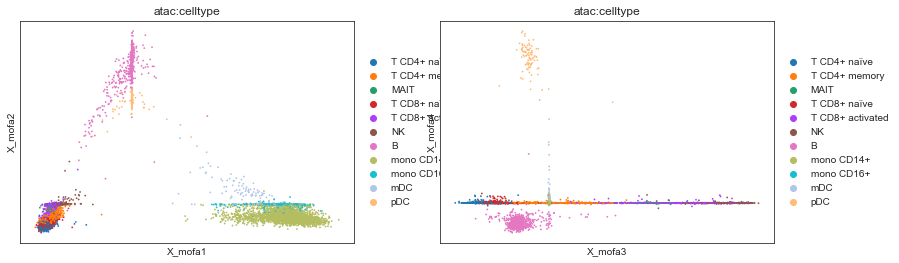

In [41]:
mu.pl.mofa(mdata, color="atac:celltype", components=["1,2", "3,4"])

We can generate custom plots with `matplotlib` and `seaborn`:

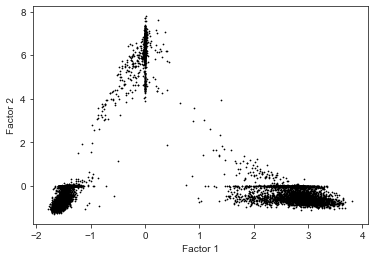

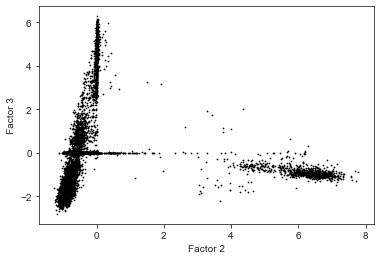

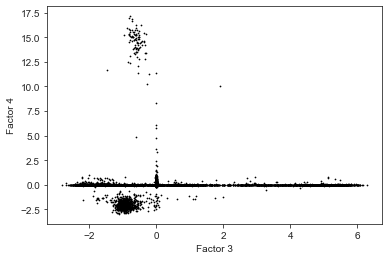

In [52]:
df = pd.DataFrame(mdata.obsm["X_mofa"])
df.columns = [f"Factor {i+1}" for i in range(df.shape[1])]

plot_scatter = lambda i: sns.scatterplot(data=df, x=f"Factor {i+1}", y=f"Factor {i+2}", color="black", linewidth=0, s=3)

for i in range(3):
    plt.figure()
    plot_scatter(i)

We can then use this embedding to compare cell type annotation performed individually on each modality and to annotate cell types jointly on both omics.

For a more detailed exploration of the trained MOFA model in Python, please see [this notebook](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/3.1-MOFA-Model-Interpretation.ipynb) that demonstrated how to use [mofa×](https://github.com/gtca/mofax) to interpret the MOFA model that we've trained on the ATAC+RNA multi-omics data.
